# Data Augmentation with ResNet18 

In [2]:
#import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np

#ici ça normalise 

In [3]:
#normalize
import torch
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader
from tqdm import tqdm  # pour la barre de progression

base_dir = "ipeo_hurricane_for_students"

# juste transformer en tensor pour calcul
transform = T.Compose([T.ToTensor()])

train_ds = datasets.ImageFolder(f"{base_dir}/train", transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=4)

mean = 0.
std = 0.
nb_samples = 0

for imgs, _ in tqdm(train_loader, desc="Calcul mean/std"):
    batch_samples = imgs.size(0)
    imgs = imgs.view(batch_samples, imgs.size(1), -1)  # aplatir H*W pour chaque canal
    mean += imgs.mean(2).sum(0)
    std += imgs.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std  /= nb_samples

print("mean:", mean)
print("std:", std)


Calcul mean/std: 100%|██████████| 297/297 [02:08<00:00,  2.32it/s]

mean: tensor([0.3518, 0.3832, 0.2849])
std: tensor([0.1137, 0.0985, 0.0997])


In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
#recuperation mean et std
normalize = T.Normalize(mean, std)
# we invert normalization for plotting later
std_inv = 1 / (std + 1e-7)
unnormalize = T.Normalize(-mean * std_inv, std_inv)

transforms_train = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.RandomGrayscale(p=0.1),
    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.3),
    T.ToTensor(),
    normalize
])
transforms_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])
base_dir = "ipeo_hurricane_for_students"
#import datasets with transformations
train_ds = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transforms_train)
val_ds   = datasets.ImageFolder(os.path.join(base_dir, "validation"), transform=transforms_val)
test_ds  = datasets.ImageFolder(os.path.join(base_dir, "test"), transform=transforms_val)

# Now subset stratification

In [5]:
import random
from collections import defaultdict
from torch.utils.data import Subset

def make_stratified_subset(imagefolder_dataset, samples_per_class=10, seed=42):
    random.seed(seed)
    class_indices = defaultdict(list)

    for idx, (_, label) in enumerate(imagefolder_dataset.samples):
        class_indices[label].append(idx)

    selected_indices = []
    for label, indices in class_indices.items():
        k = min(len(indices), samples_per_class)
        selected_indices.extend(random.sample(indices, k))

    return Subset(imagefolder_dataset, selected_indices)

# Create debug dataset 

In [6]:
use_subset = True
samples_per_class = 10

if use_subset:
    train_dataset = make_stratified_subset(train_ds, samples_per_class)
else:
    train_dataset = train_ds

# Light Dataloader 

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0
)

# print batch

In [8]:
import matplotlib.pyplot as plt

def show_batch(loader, classes, unnormalize):
    images, labels = next(iter(loader))

    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    for img, label, ax in zip(images, labels, axes.flat):
        img = unnormalize(img)
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(classes[label])
        ax.axis("off")

    plt.suptitle("Train batch with data augmentation")
    plt.tight_layout()
    plt.show()


Classes : ['damage', 'no_damage']
Nombre total train : 19000
Nombre utilisé (subset) : 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


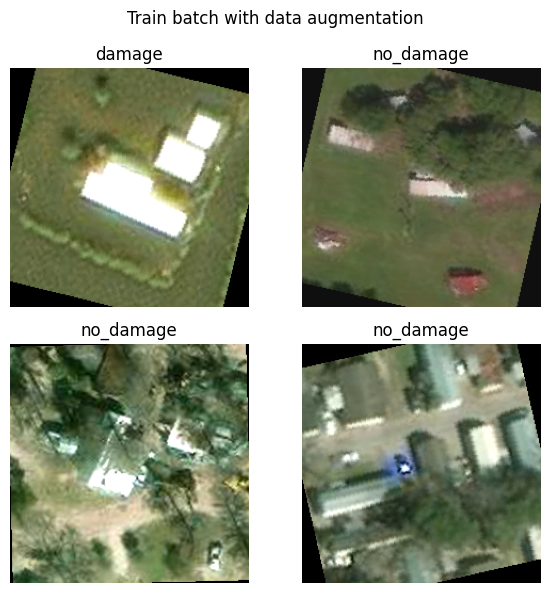

In [9]:
#lastblock 
print("Classes :", train_ds.classes)
print("Nombre total train :", len(train_ds))
print("Nombre utilisé (subset) :", len(train_dataset))

show_batch(train_loader, train_ds.classes, unnormalize)